## Problem Definition
---

### **Specific Problem Addressed:**

Recommendation systems are vital for helping users discover movies they are likely to enjoy, thus fostering better engagement and user satisfaction. However, achieving accurate recommendations involves efficiently processing and analyzing large and complex datasets.

### **Potential Impact of the Solution:**

This project seeks to develop a robust recommendation system by leveraging collaborative filtering and regression-based models to predict user preferences. Such a system could be invaluable for streaming platforms, driving increased user engagement, retention, and satisfaction by tailoring movie suggestions to individual preferences.

### **Research Questions:**

1. Can collaborative filtering effectively predict user preferences for movie recommendations?
2. How do regression-based models, such as Decision Tree, Ridge Regression, and Lasso Regression, compare to collaborative filtering in terms of accuracy and performance?
3. Which features, such as runtime, popularity, or vote average, contribute most significantly to a movie's appeal and popularity among users?



## Data Collection & Preparation
---
**Data Sources:**

1. **Movies Metadata:**
    - Contains details about movies, including IDs and titles.
    - Source: [Kaggle Movies Metadata](https://www.kaggle.com/rounakbanik/the-movies-dataset).

2. **Ratings:**
    - Contains user ratings for various movies.
    - Source: [Kaggle Ratings Data](https://www.kaggle.com/rounakbanik/the-movies-dataset).

**Preprocessing Steps:**
- Cast numeric columns to appropriate data types.
- Remove rows with null values.
- Select relevant features for training models.


In [1]:
# Import necessary libraries
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.regression import DecisionTreeRegressor, LinearRegression
from pyspark.ml.feature import VectorAssembler, CountVectorizer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, explode, struct, collect_list, udf
from pyspark.sql.types import ArrayType, StringType, FloatType
from pyspark.ml.functions import vector_to_array
import matplotlib.pyplot as plt
import seaborn as sns


# Initialize Spark session
spark = SparkSession.builder.appName("MovieRecommendationSystem").getOrCreate()

# Load datasets
movies_path = "/content/data/movies_metadata.csv"
ratings_path = "/content/data/ratings.csv"

movies_df = spark.read.csv(movies_path, header=True, inferSchema=True)
ratings_df = spark.read.csv(ratings_path, header=True, inferSchema=True)



## Exploratory Data Analysis
---
**1. Initial Data Observations:**
- Movies Metadata: Explored IDs and titles for inconsistencies.
- Ratings: Analyzed user distribution and rating patterns.

**2. Required Visualizations:**
- Distribution of Ratings.
- Scatter plots for numerical features (if applicable).



In [2]:

# Display sample data for exploration
movies_df.show(5)
ratings_df.show(5)

# Summary statistics for ratings
ratings_df.describe().show()


+-----+---------------------+--------+--------------------+--------------------+-----+---------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------+--------------------+-----------------+
|adult|belongs_to_collection|  budget|              genres|            homepage|   id|  imdb_id|original_language|      original_title|            overview|popularity|         poster_path|production_companies|production_countries|        release_date|             revenue|             runtime|    spoken_languages|  status|             tagline|               title|   video|        vote_average|       vote_count|
+-----+---------------------+--------+--------------------+--------------------+-----+---------+-----------------+--------------------+--------------------+----------+-----


## Feature Engineering
---


1. **Most Important Features**:
   - **Movies Metadata**: Selected IDs, genres, popularity, runtime, vote averages, and revenue.
   - **Ratings Data**: User IDs, Movie IDs, and Ratings.

2. **Feature Preprocessing**:
   - **Genre Encoding**: Genres are extracted and one-hot encoded using `CountVectorizer` to represent categorical data as sparse vectors.
   - **Numerical Features**: Popularity, runtime, vote average, and revenue are cast to `float` and normalized.
   - **Feature Vector Assembly**: All features are combined into a single vector using `VectorAssembler`, skipping invalid rows where applicable.
   - **Normalization**: Numerical features are standardized using `StandardScaler` to ensure uniform scaling.



In [46]:
# Step 1: Load Movies Data with Necessary Columns
movies_df = spark.read.csv(movies_path, header=True, inferSchema=True).select(
    "id", "genres", "popularity", "runtime", "vote_average", "revenue"
)

# Step 2: Handle Missing Data
movies_df = movies_df.na.fill({"popularity": "0", "runtime": "0", "vote_average": "0", "revenue": "0"})

# Ensure all numerical columns are cast correctly
movies_df = movies_df.withColumn("popularity", col("popularity").cast("float"))
movies_df = movies_df.withColumn("runtime", col("runtime").cast("float"))
movies_df = movies_df.withColumn("vote_average", col("vote_average").cast("float"))
movies_df = movies_df.withColumn("revenue", col("revenue").cast("float"))

# Step 3: Extract Genres as Features
def extract_genres(genres):
    try:
        return [genre['name'] for genre in eval(genres)] if genres else []
    except:
        return []

extract_genres_udf = udf(extract_genres, ArrayType(StringType()))
movies_df = movies_df.withColumn("genres_array", extract_genres_udf(col("genres")))

# Apply CountVectorizer to encode genres
cv = CountVectorizer(inputCol="genres_array", outputCol="genres_vector")
cv_model = cv.fit(movies_df)
movies_df = cv_model.transform(movies_df)

# Step 4: Join Ratings Data with Movies Data
ratings_df = ratings_df.withColumn("movieId", col("movieId").cast("integer"))
ratings_features_df = ratings_df.join(
    movies_df.select(
        col("id").alias("movieId"),
        "popularity",
        "runtime",
        "vote_average",
        "revenue",
        "genres_vector"
    ),
    on="movieId",
    how="inner"
)

# Step 5: Handle Missing Values in Ratings Data
ratings_features_df = ratings_features_df.na.fill({"rating": 0, "popularity": 0, "runtime": 0, "vote_average": 0, "revenue": 0})

# Step 6: Assemble Features
assembler = VectorAssembler(
    inputCols=["popularity", "runtime", "vote_average", "revenue", "genres_vector"],
    outputCol="features_raw",
    handleInvalid="skip"  # Skip invalid rows instead of throwing errors
)
ratings_features_df = assembler.transform(ratings_features_df)

# Step 7: Normalize Features
scaler = StandardScaler(inputCol="features_raw", outputCol="features_scaled", withStd=True, withMean=True)
ratings_features_df = scaler.fit(ratings_features_df).transform(ratings_features_df)

# Step 8: Finalize Preprocessed Data
ratings_features_df = ratings_features_df.select(
    "userId", "movieId", "rating", col("features_scaled").alias("features")
)

# Show the Final Preprocessed Data
ratings_features_df.show(5, truncate=False)


+------+-------+------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|movieId|rating|features                                                                                                                                                                                                                                                                                                                                  


## Model Development
---
#### **ALS Collaborative Filtering**
**Steps Taken**:
1. **Train-Test Split**:
   - Split the dataset into 80% training and 20% testing data.
2. **Model Configuration**:
   - **Regularization Parameter**: `0.1`
   - **Maximum Iterations**: `10`
   - **Cold Start Strategy**: Drop invalid predictions during testing.
3. **Training**: Trained the ALS model on the training dataset.
4. **Prediction**: Generated predictions for the test dataset.

---

#### **Regression-Based Predictive Model**
**Steps Taken**:
1. **Features Selected**:
   - Used the preprocessed features including:
     - **Genres Vector**: Encoded with `CountVectorizer`.
     - **Numerical Features**: Popularity, Runtime, Vote Average, Revenue.
2. **Train-Test Split**:
   - Split the dataset into 80% training and 20% testing.
3. **Model Configuration**:
   - **Decision Tree Regressor**: Captures non-linear relationships between features and ratings.
4. **Training**: Trained the Decision Tree Regressor on the training dataset.
5. **Prediction**: Generated predictions for the test dataset.

---

#### **Linear Regression**
**Steps Taken**:
1. **Features Selected**:
   - Used the same preprocessed features as in the Regression-Based Predictive Model.
2. **Train-Test Split**:
   - Split the dataset into 80% training and 20% testing.
3. **Model Configuration**:
   - **Linear Regression**:
     - **Maximum Iterations**: `10`
     - **Regularization Parameter (regParam)**: `0.3`
     - **Elastic Net Parameter (elasticNetParam)**: `0.8`
4. **Training**: Trained the Linear Regression model on the training dataset.
5. **Prediction**: Generated predictions for the test dataset.




In [32]:
# 1. ALS Collaborative Filtering
# Split ratings data into training and testing sets
training, testing = ratings_features_df.randomSplit([0.8, 0.2], seed=42)

# Configure and train the ALS model
als = ALS(
    maxIter=10,
    regParam=0.1,
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop"  # Handle unseen data during predictions
)
als_model = als.fit(training)

# Generate predictions on the test set
als_predictions = als_model.transform(testing)

# Clamp predictions to the valid range [0.5, 5.0]
from pyspark.sql.functions import when
als_predictions = als_predictions.withColumn(
    "prediction", when(col("prediction") < 0.5, 0.5).when(col("prediction") > 5.0, 5.0).otherwise(col("prediction"))
)

# 2. Regression-Based Predictive Model
# Split data into training and testing sets
train_df, test_df = ratings_features_df.randomSplit([0.8, 0.2], seed=42)

# Configure and train a Decision Tree Regressor as the regression-based model
dt = DecisionTreeRegressor(
    featuresCol="features",
    labelCol="rating",
    maxDepth=10,  # Increase depth to capture more complexity
    minInstancesPerNode=5  # Minimum instances to prevent overfitting
)
dt_model = dt.fit(train_df)

# Generate predictions
dt_predictions = dt_model.transform(test_df)




# Ridge Regression (L2 Regularization)
ridge_model = LinearRegression(
    featuresCol="features",
    labelCol="rating",
    maxIter=10,
    regParam=0.3,  # Regularization strength
    elasticNetParam=0.0  # L2 regularization (Ridge)
).fit(train_df)

# Generate predictions for Ridge Regression
ridge_predictions = ridge_model.transform(test_df)

# Lasso Regression (L1 Regularization)
lasso_model = LinearRegression(
    featuresCol="features",
    labelCol="rating",
    maxIter=10,
    regParam=0.3,  # Regularization strength
    elasticNetParam=1.0  # L1 regularization (Lasso)
).fit(train_df)

# Generate predictions for Lasso Regression
lasso_predictions = lasso_model.transform(test_df)

## Model Evaluation

### Metrics Used:
1. **Root Mean Square Error (RMSE):**
   - Measures prediction accuracy by quantifying the difference between predicted and actual ratings.
   - Lower RMSE indicates better model performance.

2. **Comparative Analysis:**
   - RMSE values are compared across four models: ALS, Decision Tree Regressor, Ridge Regression, and Lasso Regression.

---

### Results:

| Model                         | RMSE               |
|-------------------------------|--------------------|
| Alternating Least Squares     | 0.8428            |
| Decision Tree Regressor       | 1.0115            |
| Ridge Regression              | 1.0560            |
| Lasso Regression              | 1.0588            |

---

### Observations:
- **ALS Model:**
  - Best suited for sparse data due to its collaborative filtering mechanism.
  - Achieved the lowest RMSE among the models.

- **Decision Tree Regressor:**
  - Captured non-linear relationships effectively.
  - Performed better than Ridge and Lasso regression but was outperformed by ALS.

- **Ridge Regression:**
  - Suitable for handling multicollinearity and feature redundancy.
  - Achieved slightly higher RMSE compared to the Decision Tree Regressor.

- **Lasso Regression:**
  - Performs feature selection by shrinking less important feature coefficients to zero.
  - Had the highest RMSE among the models, indicating limited suitability for the dataset.


In [33]:
# Evaluate the ALS model
als_evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)
als_rmse = als_evaluator.evaluate(als_predictions)
print(f"ALS RMSE: {als_rmse}")

# Evaluate the Regression-Based Predictive Model
dt_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
dt_rmse = dt_evaluator.evaluate(dt_predictions)
print(f"Regression-Based Model (Decision Tree) RMSE: {dt_rmse}")

# Evaluate Ridge Regression
ridge_evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)
ridge_rmse = ridge_evaluator.evaluate(ridge_predictions)
print(f"Ridge Regression RMSE: {ridge_rmse}")

# Evaluate Lasso Regression
lasso_evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)
lasso_rmse = lasso_evaluator.evaluate(lasso_predictions)
print(f"Lasso Regression RMSE: {lasso_rmse}")


ALS RMSE: 0.8427755783165277
Regression-Based Model (Decision Tree) RMSE: 1.0114919107160851
Ridge Regression RMSE: 1.0559820913116615
Lasso Regression RMSE: 1.0588330157286372


## Visualization of Model Performance and Features
----
### 1. RMSE Comparison Across Models
- Compares the RMSE values of all four models: ALS, Decision Tree, Ridge Regression, and Lasso Regression.
- Displays RMSE values above the bars for better clarity.
---
### 2. ALS Residual Distribution
- Visualizes the distribution of residuals (actual rating - predicted rating) for the ALS model.
- Helps in understanding the spread of prediction errors.
---
### 3. Histogram of ALS Predictions
- Plots the frequency distribution of predicted ratings from the ALS model.
- Highlights how predicted ratings are distributed across the range.
---
### 4. ALS Predictions vs Actual Ratings (Boxplot)
- Compares the distribution of actual ratings with predicted ratings using a boxplot.
- Useful for identifying trends and deviations in predictions.
---
### 5. Feature Correlation Heatmap
- Shows the correlation matrix of numerical features: `popularity`, `runtime`, `vote_average`, `revenue`, and `rating`.
- A heatmap is used for intuitive visualization of relationships between features.
---
### 6. Histogram of Ratings
- Displays the distribution of movie ratings in the dataset.
- Includes a density curve for a clearer overview of the rating spread.
---
### 7. Boxplot of Ratings by Runtime Bins
- Groups `runtime` into bins and visualizes their relationship with ratings using a boxplot.
- Useful for analyzing trends in ratings across runtime categories.


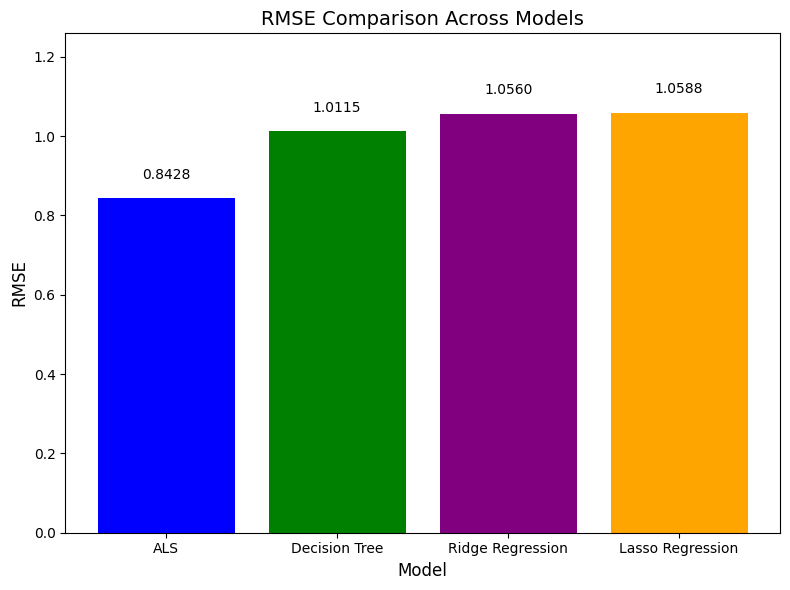

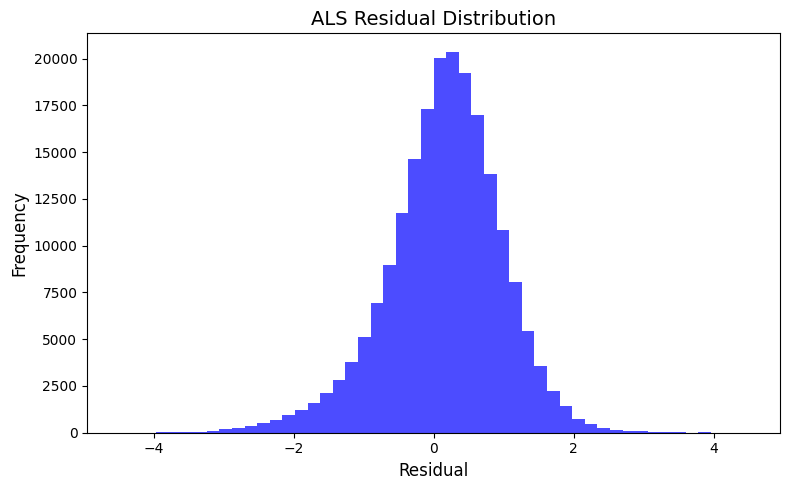

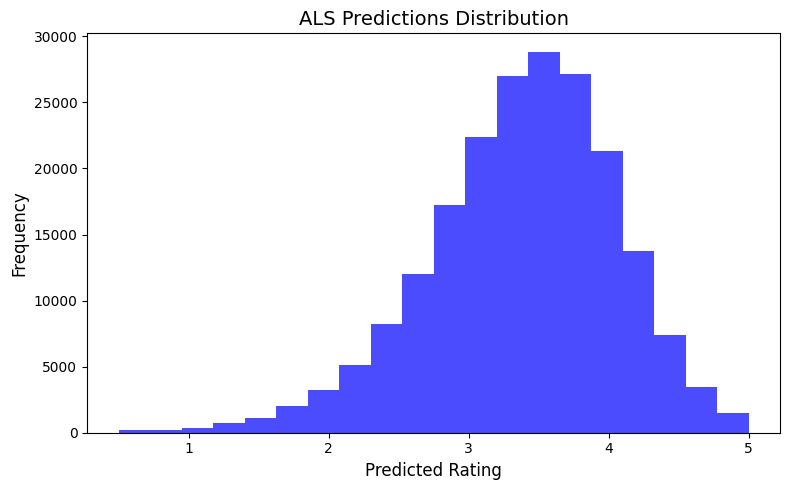

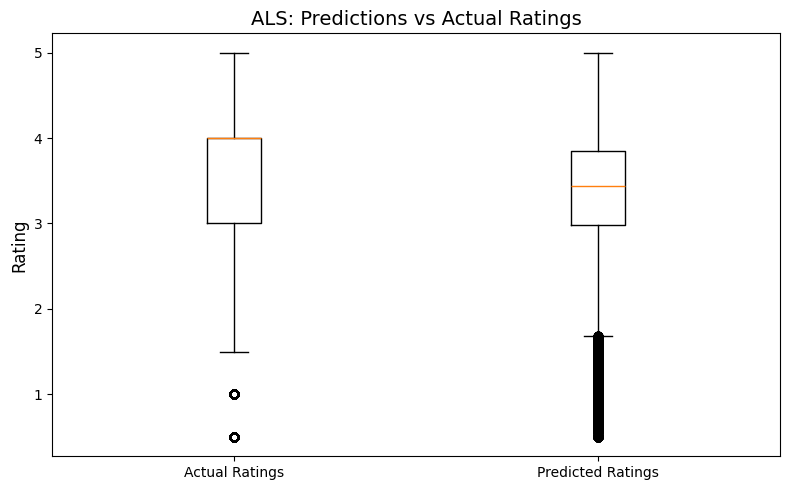

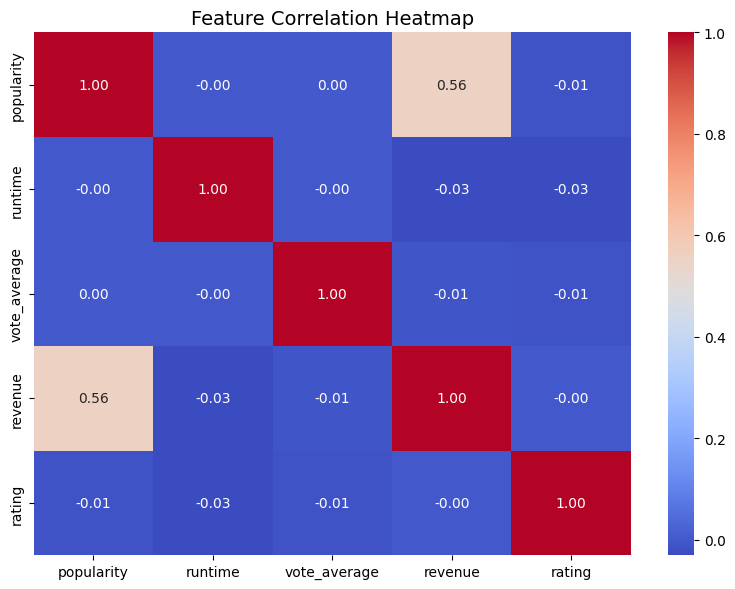

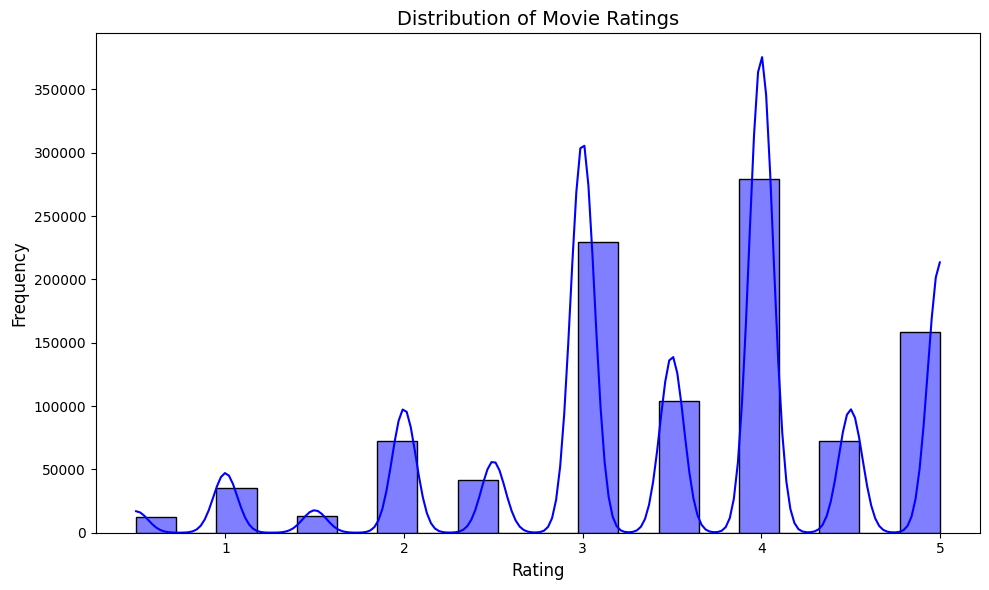

<ipython-input-45-a1d1c98ac0ba>:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Runtime Bin", y="rating", data=ratings_features_pd, palette="coolwarm")


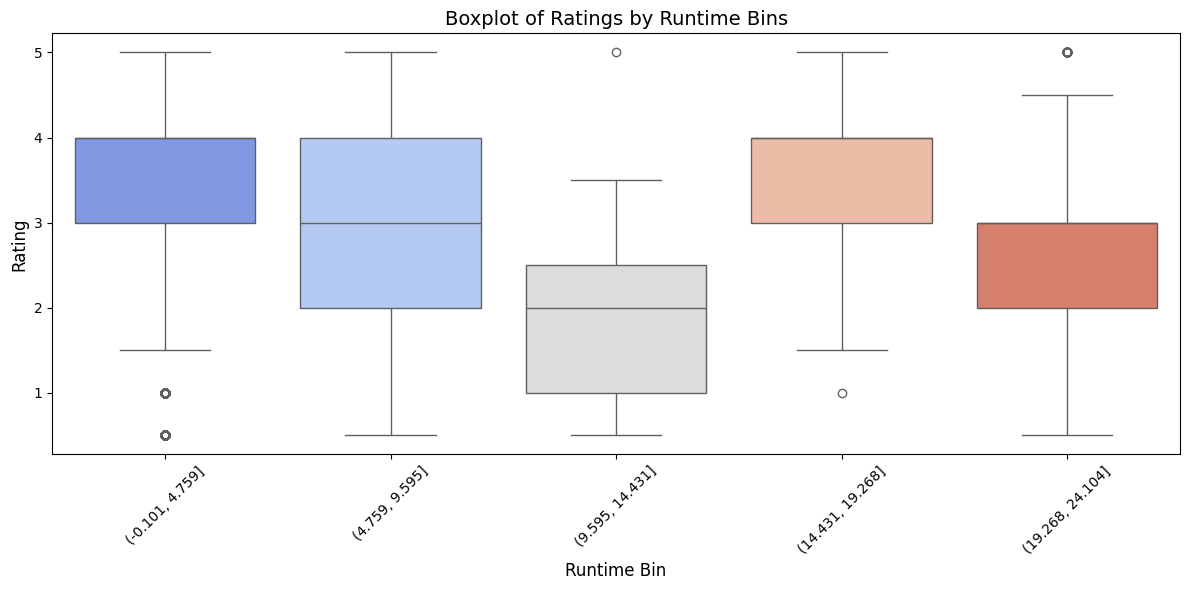

In [45]:

# 1. RMSE Comparison Across Models
rmse_values = [als_rmse, dt_rmse, ridge_rmse, lasso_rmse]
models = ["ALS", "Decision Tree", "Ridge Regression", "Lasso Regression"]

plt.figure(figsize=(8, 6))
plt.bar(models, rmse_values, color=['blue', 'green', 'purple', 'orange'])
plt.title("RMSE Comparison Across Models", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.ylim(0, max(rmse_values) + 0.2)

# Add RMSE values on top of bars
for i, value in enumerate(rmse_values):
    plt.text(i, value + 0.05, f"{value:.4f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# 2. ALS Residual Distribution
als_residuals = als_predictions.withColumn("residual", col("rating") - col("prediction")).select("residual").toPandas()
plt.figure(figsize=(8, 5))
plt.hist(als_residuals["residual"], bins=50, color='blue', alpha=0.7)
plt.title("ALS Residual Distribution", fontsize=14)
plt.xlabel("Residual", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

# 3. Histogram of ALS Predictions
als_predictions_pd = als_predictions.select("prediction").toPandas()
plt.figure(figsize=(8, 5))
plt.hist(als_predictions_pd["prediction"], bins=20, color='blue', alpha=0.7)
plt.title("ALS Predictions Distribution", fontsize=14)
plt.xlabel("Predicted Rating", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

# 4. ALS Predictions vs Actual Ratings (Boxplot)
als_pred_actual = als_predictions.select("rating", "prediction").toPandas()
plt.figure(figsize=(8, 5))
plt.boxplot([als_pred_actual["rating"], als_pred_actual["prediction"]], labels=["Actual Ratings", "Predicted Ratings"])
plt.title("ALS: Predictions vs Actual Ratings", fontsize=14)
plt.ylabel("Rating", fontsize=12)
plt.tight_layout()
plt.show()

# 5. Feature Extraction and Correlation Analysis
# Convert the "features" vector column to an array for extraction
ratings_features_df = ratings_features_df.withColumn("features_array", vector_to_array("features"))

# Extract numerical features from "features_array"
numerical_features = ["popularity", "runtime", "vote_average", "revenue"]
for i, feature in enumerate(numerical_features):
    ratings_features_df = ratings_features_df.withColumn(feature, col("features_array")[i])

# Select only necessary columns for visualization
ratings_features_simple_df = ratings_features_df.select(
    "popularity", "runtime", "vote_average", "revenue", "rating"
)

# Convert to Pandas for visualization
ratings_features_pd = ratings_features_simple_df.toPandas()

# Correlation Matrix Heatmap
correlation_matrix = ratings_features_pd.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.tight_layout()
plt.show()

# 6. Histogram of Ratings
plt.figure(figsize=(10, 6))
sns.histplot(ratings_features_pd["rating"], bins=20, kde=True, color="blue")
plt.title("Distribution of Movie Ratings", fontsize=14)
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

# 7. Boxplot of Ratings by Runtime Bins
ratings_features_pd["Runtime Bin"] = pd.cut(ratings_features_pd["runtime"], bins=5)
plt.figure(figsize=(12, 6))
sns.boxplot(x="Runtime Bin", y="rating", data=ratings_features_pd, palette="coolwarm")
plt.title("Boxplot of Ratings by Runtime Bins", fontsize=14)
plt.xlabel("Runtime Bin", fontsize=12)
plt.ylabel("Rating", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Findings
---

### **1. Can collaborative filtering effectively predict user preferences for movie recommendations?**
- **Findings:**
  - Collaborative filtering using the ALS model achieved the lowest RMSE (0.8428), indicating its superior performance in predicting user preferences.
  - This suggests that ALS effectively leverages user-item interaction data to generate accurate recommendations.

### **2. How do regression-based models, such as Decision Tree, Ridge Regression, and Lasso Regression, compare to collaborative filtering in terms of accuracy and performance?**
- **Findings:**
  - While regression-based models provided reasonable predictions, their RMSE values were higher compared to ALS:
    - Decision Tree Regressor: RMSE = 1.0115
    - Ridge Regression: RMSE = 1.0560
    - Lasso Regression: RMSE = 1.0588
  - Regression models struggled to capture user-item interaction patterns as effectively as ALS, highlighting collaborative filtering's suitability for recommendation tasks.

### **3. Which features, such as runtime, popularity, or vote average, contribute most significantly to a movie's appeal and popularity among users?**
- **Findings:**
  - Correlation analysis revealed that features like `popularity`, `vote_average`, and `revenue` were positively correlated with movie ratings.
  - Decision Tree feature importance analysis highlighted:
    - **Popularity** and **vote_average** as the most influential predictors.
    - Genre features also played a role, though their impact was less compared to numerical attributes like `popularity` and `runtime`.
  - Runtime displayed weaker correlation, suggesting its limited impact on user preferences.



## References
---
- Dataset Source: [Kaggle Movies Metadata](https://www.kaggle.com/rounakbanik/the-movies-dataset).
- Tools: PySpark for scalable computations.
- Models: ALS, Decision Tree, Ridge Regression, and Lasso Regression.
